# Kendrick Series Attribution

This notebook shows how to perform an attribution of a spectra using a Kendrick Series attribution
algorothm.

In [2]:
# this cell import the need modules
from pyc2mc.core.formula_grid import FormulaGrid
from pyc2mc.processing.kendrick_attribution import kendrick_attribution
from pyc2mc.io.peaklist import read_peaklist
from pyc2mc.plotinator.widgenator import display_error, display_chem_classes

## 1. Create the Molecular Formula Grid 

This grid aims to contains all the possible molecular formula assuming
some constrains including the number of each element and the presence or
not of some isotopes. 

### Set up the formula grid

In order to set up the grid you have to define the constrains which are
used to define the `FormulaGrid` class. The parameters are:

* `elements`: list of elements, at least C and H.
* `limits`: minimum and maximum number of each element
* `H_C_bounds`: boundaries of the H over C ratio
* `dbe_bouds`: boundaries of the DBE (Double Bond Equivalent)
* `mass_bounds`: boundaries of the nominal masses
* `polarity`: ionization charge

Additionally you can consider the two following options:

* `element_ratio`: boundaries of the ELM1 to ELM2 ratio as a dictionary.
* `isotopes`: dictionary of isotopes to be included in the formula list, see below
* `combine_isotopes`: list of dictionaries that defines combinations

Here is the syntax:

### Select isotopes

If you want to consider isotopes, you have to define which ones you want
to consider and in which quantity.

For example, in the following we will consider formula that include

* one $^{13}C$
* two $^{13}C$
* one $^{15}N$
* one $^{18}O$
* one $^{34}S$

The syntax is the following

```python
isotopes = {
    (6, 13): 2,  # one & two atoms of 13C
    (7, 15): 1,  # one atom of 15N
    (8, 18): 1,  # one atom of 18O
    (16, 34): 1, # one atom of 34S
}
```

On each line we have

```
(atomic_number, mass_number, index_position): number_of_isotope,
```

Here is the definition:

In [3]:
# define the considered isotopes 
# {(Atomic_number, mass_number, position): number_of_isotopes, ...}
isotopes = {
    (5, 10): 1,  # one atom of 10B
    (6, 13): 2,  # one and two atoms of 13C
    (8, 18): 1,  # one atom of 18O
}

Now we define the formula grid:

In [4]:
fgrid_example1 = FormulaGrid(
    # default element symbols
    elements=["C", "H", "N", "O", "B"],
    # [min, max] value of each element in the same order
    limits=[[1, 100], [1, 200], [0, 2], [0, 20], [0, 1]],
    # boundaries of the H over C ration
    H_C_bounds=[0.3, 2.4],
    # boundaries of DBE
    dbe_bounds=[0, 50],
    # boundaries of nominal mass
    mass_bounds=[150, 1000],
    polarity=-1,
    # O over C ratio
    element_ratios={('O', 'C'): (0, 1.4)},
    # define selected isotopes
    isotopes=isotopes,
    combine_isotopes=[{(5, 10): 1,(6, 13): 1}]
)

## 2. Read and plot a PeakList file

The assignment will be done from a peak list contained in a text file. You
have to provide the *path* (namely the location) of the file on your 
computer. The easiest way is to put the data in the same folder of the 
notebook or in a subfolder.

In this example, the [Biofuel_withB-containingSpecies file](./data/Biofuel_withB-containingSpecies.csv)
will be used.

In [5]:
# reading from predator file
input_path='./data/Biofuel_withB-containingSpecies.csv'
pl_B = read_peaklist(input_path, fmt="predator")

Plot the data read from the peak list file:

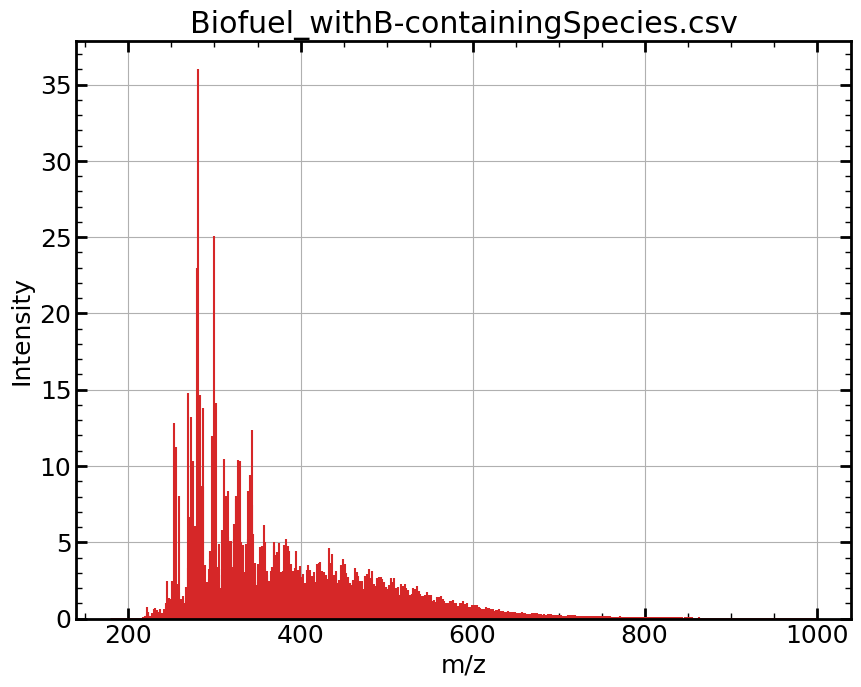

In [6]:
pl_B.plot()

## 3. Performing the attribution 

An example is shown to perform the attribution of a peak list using the Ion Molecular Formula Assignment 
Kendrick-Series-Based Algorithm. This algorithm proceed in three steps:

1. Get the Kendrick series. The default building block is CH2.
2. Attribute the Kendrick Series, starting from the most intense one and using the peak
   of the series at the lowest m/z value (or the one with a S/N value above 50).
   The formula is determined by looking for
   the <sup>13</sup>C isotope of this peak.
3. Other peaks are attributed using a lowest error algorithm.

To perform the attribution you have to provide:

* the previously set formula grid
* the maximum error in ppm (lamda_parameter) used to define if a mass is associated to a formula. This parameter is also needed to get the kendrick series.
* the peak list
* you should decide if working with intensities or SN.
* the isotopic pattern to perform assignments could be set by giving a tuple (Z, A)
* finally the building block of the kendrick series could be also define, 'C1 H2', 'C1 H1 O1', etc...

`ks_kwargs` is a list of parameters for Kendrick series detection:

* `min_length` is the minimum number of peak to be considered as a series
* `n_max_hole` is the largest number of missing peak before the series is cut

* Execute the assignment as follows :

In [7]:
attributed_peaklist, _ = kendrick_attribution(
    peaklist=pl_B,
    formula_grid=fgrid_example1,
    lambda_parameter=0.3, # ppm
    building_block='C1 H2',
    use_SN=True,
    use_isotopes=True,
    isotopic_pattern=(6, 13),
    ks_kwargs=dict(min_length=8, n_max_hole=1)
)

# Kendrick series: 693


Compute the percentage of peaks for which a formula was identified including isotopes it also shows the existing candidates found:

In [8]:
attributed_peaklist.summary()

 Attribution results:
 Total number of peaks: 17667
 Attributed peaks     : 6095
 Mean error (ppm)     : 0.01481
 Std error (ppm)      : 0.06674
 Attributed percentage: 34.5 %
 hits percentage      : 79.91 %


In [9]:
attributed_peaklist.get_attribution_stats()

# peaks     % peaks   intensity  percentage
method                                                                
hits                          6095   34.499349  2819.98596   79.910001
no_hits                      11572   65.500651   708.96652   20.089999
kendrick_isotopes             2544   14.399728   518.32572   14.687807
kendrick_isotopic_pattern     3551   20.099621  2301.66024   65.222194
total                        17667  100.000000  3528.95248  100.000000

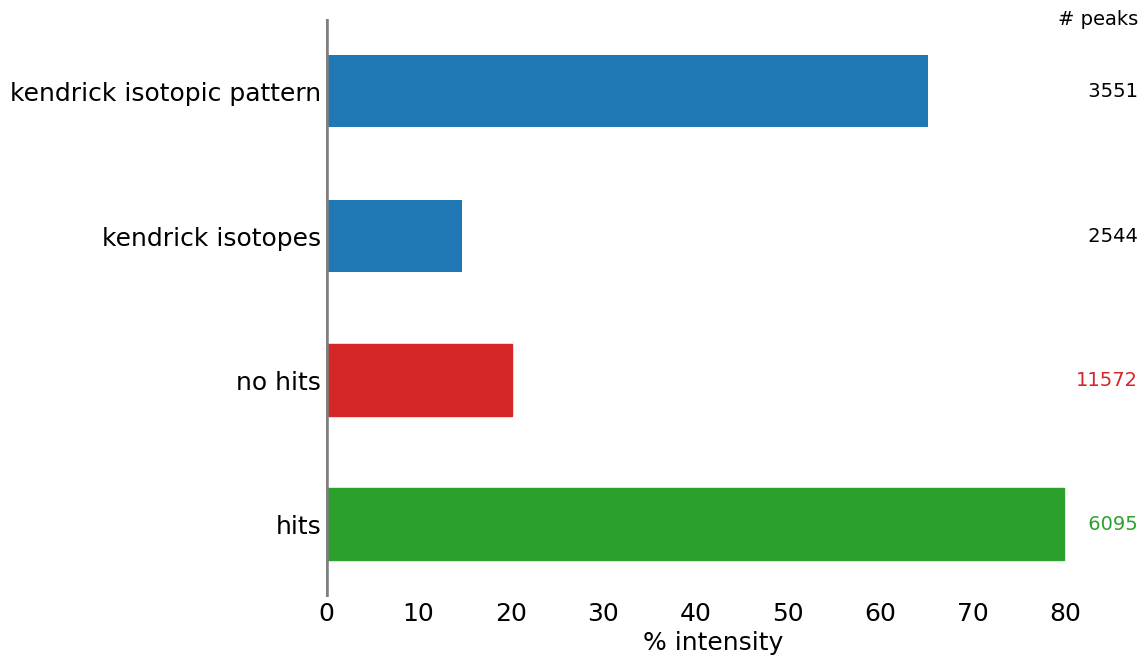

In [10]:
attributed_peaklist.plot.plot_attribution_stats()

## 4. Obtain information from the attributed peaklist

An object with the properties of an attributed peak list could be used to obtain a lot of information about the attributions :

In [11]:
display_error(attributed_peaklist, threshold=1)

Visualize the attributed families of compounds (monoisotopic families).

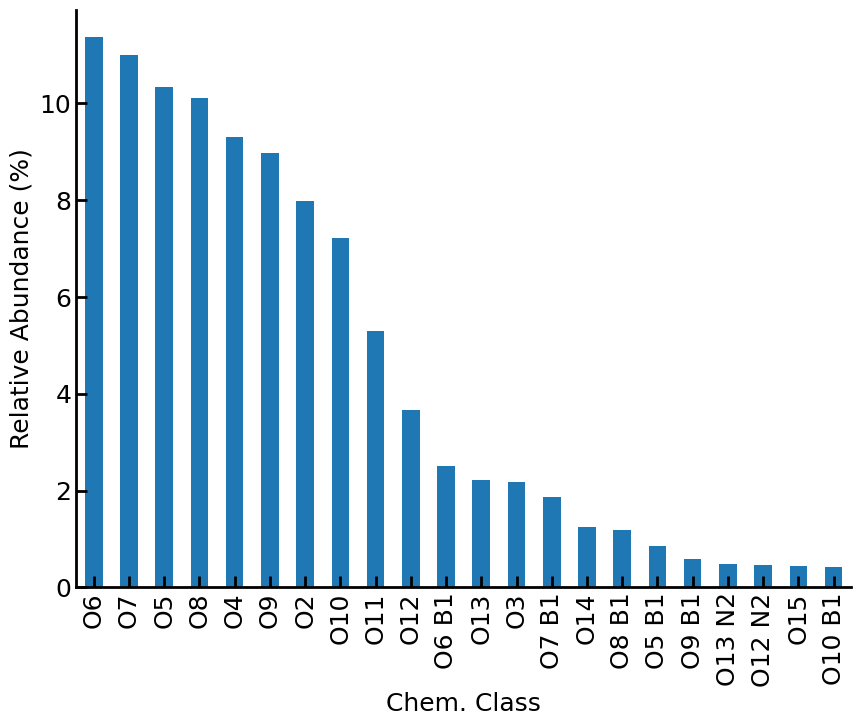

In [12]:
attributed_peaklist.plot.plot_classes(threshold=0.25)

Let's see the DBE plot of the most abundant family: 'O6 B1 '

In [13]:
display_chem_classes(attributed_peaklist)

## 6. Save results

Save the results into a .csv output file using the attributed peak list object.

```python
filename='Biofuel_KendrickAttribution2.csv'
attributed_peaklist.to_csv(filename)
```

To obtain only attributed results as a DataFrame just write:

In [14]:
attributed_peaklist.to_dataframe(attributed_only=True, full_data=True).head(10)

mz  intensity          formula  polarity       SN  error_ppm  \
7532  231.02990    0.03820        C12 H7 O5        -1   3.8639  -0.013403   
8868  231.05103    0.04263        C9 H11 O7        -1   4.4272  -0.016137   
7508  231.06628    0.70768       C13 H11 O4        -1  88.8802   0.010442   
9088  231.10267    0.39004       C14 H15 O3        -1  48.5434  -0.008991   
7500  231.13905    0.09438       C15 H19 O2        -1  10.9980   0.014846   
36    232.06963    0.11363  C12 H11 O4 13C1        -1  13.4434   0.031232   
8012  233.04555    0.15041        C12 H9 O5        -1  18.1138  -0.013011   
9272  233.06666    0.08889        C9 H13 O7        -1  10.3016   0.070092   
9627  233.08193    0.53762       C13 H13 O4        -1  67.2852   0.010628   
9242  233.11833    0.15061       C14 H17 O3        -1  18.1384  -0.051533   

      attributed         attribution_method  nominal_mass  kendrick_mass  ...  \
7532        True  kendrick_isotopic_pattern           231     230.771929  ...   
8868        True  kendrick_isotopic_pattern           231     230.793035  ...   
7508        True  kendrick_isotopic_pattern           231     230.808268  ...   
9088        True  kendrick_isotopic_pattern           231     230.844618  ...   
7500        True  kendrick_isotopic_pattern           231     230.880957  ...   
36          True          kendrick_isotopes           231     231.810498  ...   
8012        True  kendrick_isotopic_pattern           233     232.785328  ...   
9272        True  kendrick_isotopic_pattern           233     232.806415  ...   
9627        True  kendrick_isotopic_pattern           233     232.821668  ...   
9242        True  kendrick_isotopic_pattern           233     232.858027  ...   

      isotopic  chem_group chem_group_mono chem_class chem_class_mono   C   H  \
7532     False           O               O         O5              O5  12   7   
8868     False           O               O         O7              O7   9  11   
7508     False           O               O         O4              O4  13  11   
9088     False           O               O         O3              O3  14  15   
7500     False           O               O         O2              O2  15  19   
36        True       O 13C               O    O4 13C1              O4  13  11   
8012     False           O               O         O5              O5  12   9   
9272     False           O               O         O7              O7   9  13   
9627     False           O               O         O4              O4  13  13   
9242     False           O               O         O3              O3  14  17   

      O  N  B  
7532  5  0  0  
8868  7  0  0  
7508  4  0  0  
9088  3  0  0  
7500  2  0  0  
36    4  0  0  
8012  5  0  0  
9272  7  0  0  
9627  4  0  0  
9242  3  0  0  

[10 rows x 21 columns]